In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
from datetime import datetime
import sys
import warnings

# Import statistical libraries
from scipy import stats
from scipy.stats import median_test, mannwhitneyu, pearsonr
from scipy.optimize import curve_fit, minimize_scalar
from scipy.integrate import quad

# Import machine learning libraries
from sklearn.preprocessing import MinMaxScaler

# Import optimization libraries
import gurobipy as gp
from gurobipy import GRB

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import custom utilities
sys.path.append('/Users/ludwigbaunach/Documents/Studium/PhD/Alaiko/Paper_1_Project/Main/src')
from utils.simulation_utils import simulation_main, create_weeks

# Configure warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
# sturucture: ["model"]["variable"]["array (7,6,400)"]
single_dict = pd.read_pickle("../data/modelling_results/workforce_results_single_all_dict231123.pickle")
c_robust_dict = pd.read_pickle("../data/modelling_results/workforce_results_robust_cost_dict231123.pickle")
p_robust_dict = pd.read_pickle("../data/modelling_results/workforce_results_robust_psi_dict231123.pickle")
#p_robust_dict = pd.read_pickle("../data/modelling_results/workforce_results_robust_psi_dict231027.pickle")

## Create Total Evaluation DF

In [3]:
# Initialize an empty DataFrame to store the evaluation metrics
evaluation_df = pd.DataFrame()

# Benchmark and Perfect Forecast Models
benchmark_model = 'L_4_sarimax'
perfect_model = 'actual'

# Variables
variables = ['cost', 'w_p', 'w_e', 'y_o', 'z', 'v']
variables_name = ['cost', 'planned_workers', 'extra_workers', 'overtime', 'backlog', 'overcapacity']

# Loop through each model to evaluate
for model, variable_dict in single_dict.items():
    
    # Initialize a dictionary to hold evaluation metrics for this model
    data_dict = {
        'model': model,
        'week': 4,
        'psi_scenario': 0.8,
        'cost_scenario': 1,
    }
    
    for variable, name in zip(variables, variables_name):
        
        # Extract and flatten weekly data
        model_data = np.sum(single_dict[model][variable], axis=1).flatten()
        bench_data = np.sum(single_dict[benchmark_model][variable], axis=1).flatten()
        perf_data = np.sum(single_dict[perfect_model][variable], axis=1).flatten()
        
        # Calculate mean, median, and sum values
        mean_value = np.mean(model_data)
        median_value = np.median(model_data)
        sum_value = np.sum(model_data)
        
        # Calculate relative performance to benchmark and perfect forecast
        rel_total_bench = np.round(((sum_value - np.sum(bench_data)) / np.sum(bench_data)) * 100, 2)
        rel_total_perf = np.round(((sum_value - np.sum(perf_data)) / np.sum(perf_data)) * 100, 2)
        
        # Calculate p-value using mann whitney u test
        _, p_value_bench = mannwhitneyu(model_data, bench_data, alternative='two-sided')
        _, p_value_perf, = mannwhitneyu(model_data, perf_data, alternative='two-sided')
        
        # Calculate p-values using t-test for 'cost' variable
        if variable == 'cost':
            _, p_value_mean_bench = mannwhitneyu(model_data, bench_data, alternative='two-sided')
            _, p_value_mean_perf = mannwhitneyu(model_data, perf_data, alternative='two-sided')
            
            # Calculate mean daily savings relative to benchmark and perfect forecast
            mean_savings_bench = np.round(np.mean(((model_data - bench_data) / bench_data) * 100),2)
            mean_savings_perf = np.round(np.mean(((model_data - perf_data) / perf_data) * 100),2)
            
            data_dict.update({
                'mean_savings_bench': mean_savings_bench,
                'mean_savings_perf': mean_savings_perf,
                f'p_value_mean_bench_{name}': p_value_mean_bench,
                f'p_value_mean_perf_{name}': p_value_mean_perf
            })
        
        # Update data_dict
        data_dict.update({
            f'mean_{name}': mean_value,
            f'median_{name}': median_value,
            f'rel_total_bench_{name}': rel_total_bench,
            f'rel_total_perf_{name}': rel_total_perf,
            f'p_value_bench_{name}': p_value_bench,
            f'p_value_perf_{name}': p_value_perf
        })
        
    # Convert data_dict to DataFrame and append to evaluation_df
    temp_df = pd.DataFrame([data_dict])
    evaluation_df = pd.concat([evaluation_df, temp_df], ignore_index=True)

# Sort DataFrame by relative performance to benchmark for 'cost'
evaluation_df.sort_values("mean_savings_bench", inplace=True)

# Display the evaluation DataFrame
evaluation_df

,model,week,psi_scenario,cost_scenario,mean_savings_bench,mean_savings_perf,p_value_mean_bench_cost,p_value_mean_perf_cost,mean_cost,median_cost,...,rel_total_bench_backlog,rel_total_perf_backlog,p_value_bench_backlog,p_value_perf_backlog,mean_overcapacity,median_overcapacity,rel_total_bench_overcapacity,rel_total_perf_overcapacity,p_value_bench_overcapacity,p_value_perf_overcapacity
45,actual,4,0.8,1,-8.26,0.00,2.390592e-22,1.000000e+00,20169.013518,14403.090836,...,-100.00,NaN,0.000000e+00,1.0,0.000000,0.000000,-100.00,NaN,0.000000e+00,1.000000e+00
67,L_4_Time_Momentum_Lag_lgbm_L_4_Time_Momentum_L...,4,0.8,1,-3.52,5.33,6.290235e-06,6.359952e-09,21221.680634,15009.761786,...,15.15,inf,1.610148e-20,0.0,1057.222489,0.000000,-62.86,inf,6.648596e-25,0.000000e+00
88,L_4_Time_Momentum_Lag_Weather_xgb_L_6_Time_Mom...,4,0.8,1,-3.43,5.29,3.415884e-06,8.376967e-09,21360.919738,14989.193593,...,17.79,inf,6.198172e-60,0.0,731.089020,0.000000,-74.31,inf,3.587186e-05,0.000000e+00
70,L_4_Time_Momentum_Lag_lgbm_L_6_Time_Momentum_L...,4,0.8,1,-3.35,5.50,1.399047e-06,1.156358e-07,21505.319157,14961.771586,...,6.26,inf,1.640727e-34,0.0,335.111831,0.000000,-88.23,inf,6.215888e-14,6.755379e-299
19,L_4_Time_Momentum_Lag_lgbm,4,0.8,1,-3.21,5.80,3.865654e-06,2.640653e-08,21422.248535,15013.973381,...,3.86,inf,1.354065e-11,0.0,810.832082,0.000000,-71.51,inf,8.688184e-10,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,L_6_ets_L_3_ets,4,0.8,1,9.17,18.69,1.160247e-01,5.755561e-33,24594.468409,14988.445496,...,-28.20,inf,5.504675e-75,0.0,17033.449432,0.000000,498.45,inf,5.985112e-113,0.000000e+00
7,L_6_ets,4,0.8,1,9.28,18.81,1.430869e-01,3.236847e-32,24655.933568,14990.474506,...,-28.17,inf,1.842570e-75,0.0,17308.336789,0.000000,508.11,inf,9.945244e-108,0.000000e+00
42,L_3_nhits,4,0.8,1,11.13,20.84,3.497342e-19,4.101267e-87,24108.868218,15734.708352,...,-27.05,inf,1.653224e-46,0.0,10075.910850,0.000000,254.01,inf,9.608474e-164,0.000000e+00
5,L_6_sarima,4,0.8,1,11.17,20.78,8.507038e-03,3.552418e-39,25060.479318,15106.469985,...,-29.36,inf,7.284863e-99,0.0,19617.635046,0.000000,589.25,inf,3.632028e-113,0.000000e+00


In [4]:
# Function to add asterisks based on p-value
def add_asterisks(value, p_value):
    if p_value <= 0.001:
        return f"{value}***"
    elif p_value <= 0.01:
        return f"{value}**"
    elif p_value <= 0.05:
        return f"{value}*"
    else:
        return f"{value}"

# Initialize an empty DataFrame to store the custom table
custom_table_df = pd.DataFrame()

# Iterate through each row in the evaluation DataFrame
for index, row in evaluation_df.iterrows():
    custom_dict = {
        'model': row['model'],
        'week': row['week'],
        'psi_scenario': row['psi_scenario'],
        'cost_scenario': row['cost_scenario'],
    }
    
    for variable, name in zip(variables, variables_name):
        
        # Averages
        if variable == "cost":
            mean_daily_savings_bench = row[f'mean_savings_bench']
            mean_daily_savings_perf = row[f'mean_savings_perf']
            p_value_mean_bench = row[f'p_value_mean_bench_{name}']
            p_value_mean_perf = row[f'p_value_mean_perf_{name}']
            
            # Add asterisks to the relative performance measures based on p-value
            rel_per_bench_str = add_asterisks(mean_daily_savings_bench, p_value_mean_bench)
            rel_per_perf_str = add_asterisks(mean_daily_savings_perf, p_value_mean_perf)
        
            # Update custom_dict
            custom_dict.update({
                f'rel_bench_mean_{name}': rel_per_bench_str,
                f'rel_perf_mean_{name}': rel_per_perf_str,
            })
        
        # Total
        rel_per_bench = row[f'rel_total_bench_{name}']
        rel_per_perf = row[f'rel_total_perf_{name}']
        p_value_bench = row[f'p_value_bench_{name}']
        p_value_perf = row[f'p_value_perf_{name}']
        
        # Add asterisks to the relative performance measures based on p-value
        rel_per_bench_str = add_asterisks(rel_per_bench, p_value_bench)
        rel_per_perf_str = add_asterisks(rel_per_perf, p_value_perf)
        
        # Update custom_dict
        custom_dict.update({
            f'rel_bench_total_{name}': rel_per_bench_str,
            f'rel_perf_total_{name}': rel_per_perf_str,
        })
        
    # Create a DataFrame with the custom data
    temp_df = pd.DataFrame(custom_dict, index=[0])
    
    # Concatenate the new DataFrame to the existing one
    custom_table_df = pd.concat([custom_table_df, temp_df], ignore_index=True)

# Save DF to Excel
custom_table_df.to_excel("../data/modelling_results/workforce_eval_single_total.xlsx")

## Create Week Evaluation DF

In [5]:
def calc_weekly_robust_savings(robust_dict):
    
    # Set-Up
    
    # Variables 
    variables = ['cost', 'w_p', 'w_e', 'y_o', 'z', 'v']
    variables_name = ['cost', 'planned_workers', 'extra_workers', 'overtime', 'backlog', 'overcapacity']

    # Initialize an empty DataFrame to store the evaluation metrics
    weekly_evaluation_df = pd.DataFrame()
    
    # Benchmark
    benchmark_model = 'L_4_sarimax'

    # Perfect Forecast
    perfect_model = 'actual'
    
    # Loop through scenarios
    for scenario in robust_dict.keys():
        # Loop through models
        for model, variable_dict in robust_dict[scenario].items():
            # Loop through weeks (first value of arrays shape) 
            for week in range(c_robust_dict[scenario][model][variables[0]].shape[0]):
                data_dict = {
                    'model': model,
                    'week': week+1,
                    'scenario': scenario,
                }

                for variable, name in zip(variables, variables_name):
                    
                    # Extract weekly aggregated data
                    weekly_model_data = np.sum(robust_dict[scenario][model][variable][week, :, :], axis=0)
                    weekly_bench_data = np.sum(robust_dict[scenario][benchmark_model][variable][week, :, :], axis=0)
                    weekly_perf_data = np.sum(robust_dict[scenario][perfect_model][variable][week, :, :], axis=0)
                    
                    # Extract total weekly data 
                    total_model_data = np.sum(robust_dict[scenario][model][variable][:, :, :], axis=1).flatten()
                    total_bench_data = np.sum(robust_dict[scenario][benchmark_model][variable][:, :, :], axis=1).flatten()
                    
                    # extract sum per week 
                    sum_value = np.sum(weekly_model_data)
                    sum_bench_value = np.sum(weekly_bench_data)
                    sum_perf_value = np.sum(weekly_perf_data)
                    
                    # extract total sum (indicated by _t_)
                    sum_t_value = np.sum(total_model_data)
                    sum_t_bench_value = np.sum(total_bench_data)
                    
                    # Calculate average and standard deviation of model (weekly)
                    median_value = np.round(np.median(weekly_model_data), 2)
                    
                    # Calculate average and standard deviation of benchmark and perfect forecast (weekly)
                    median_bench = np.round(np.median(weekly_bench_data), 2)
                    median_perf = np.round(np.median(weekly_perf_data), 2)

                    # Calculate weekly sum savings and round two 2 
                    rel_bench_values = np.round(((sum_value - sum_bench_value) / sum_bench_value) * 100, 2)
                    rel_perf_values = np.round(((sum_value - sum_perf_value) / sum_perf_value) * 100, 2)
                    
                    # Calculate total sum savings 
                    rel_t_bench_values = np.round(((sum_t_value - sum_t_bench_value) / sum_t_bench_value) * 100, 2)

                    # Calculate relative measures std
                    rel_bench_avg = np.round(np.mean(((weekly_model_data - weekly_bench_data) / weekly_bench_data) * 100), 2)
                    rel_perf_avg = np.round(np.mean(((weekly_model_data - weekly_perf_data) / weekly_perf_data) * 100), 2)
                    rel_bench_std = np.round(np.std(((weekly_model_data - weekly_bench_data) / weekly_bench_data) * 100), 2)
                    rel_perf_std = np.round(np.std(((weekly_model_data - weekly_perf_data) / weekly_perf_data) * 100), 2)
                 
                    # Calculate total mean and std
                    rel_t_avg = np.round(np.mean((total_model_data - total_bench_data) / total_bench_data) * 100, 2)
                    rel_t_std = np.round(np.std((total_model_data - total_bench_data) / total_bench_data) * 100, 2)
                    
                    # Calculate bench relative measures p-values (weekly)
                    _, p_value_bench = mannwhitneyu(weekly_model_data, weekly_bench_data, alternative='two-sided')
                    # Calculate perf relative measures p-values (weekly)
                    _, p_value_perf = mannwhitneyu(weekly_model_data, weekly_perf_data, alternative='two-sided')
                    # Calculate bench relative measures p-values (total)
                    _, p_t_value_bench = mannwhitneyu(total_model_data, total_bench_data, alternative='two-sided')
                    
                    # Add asterisks
                    rel_bench_ast = add_asterisks(rel_bench_values, p_value_bench)
                    rel_bench_ast_avg = add_asterisks(rel_bench_avg, p_value_bench)
                    
                    rel_perf_ast = add_asterisks(rel_perf_values, p_value_perf)
                    rel_perf_ast_avg = add_asterisks(rel_perf_avg, p_value_perf)
                    
                    rel_t_bench_ast = add_asterisks(rel_t_bench_values, p_t_value_bench)
                    rel_t_bench_ast_avg = add_asterisks(rel_t_avg, p_t_value_bench)

                    # Update data_dict
                    data_dict.update({
                        f'sum_{name}': sum_value,
                        f'median_{name}': median_value,
                        f'rel_bench_{name}': rel_bench_ast,
                        f'rel_bench_avg_{name}': rel_bench_ast_avg,
                        f'rel_bench_std_{name}': f'({rel_bench_std})',
                        f'p_bench_{name}': p_value_bench,
                        f'rel_perf_avg_{name}': rel_perf_ast_avg,
                        f'rel_t_bench_{name}': rel_t_bench_ast,
                        f'rel_t_bench_avg_{name}': rel_t_bench_ast_avg,
                        f'rel_t_bench_std_{name}': f'({rel_t_std})',
                    })

                # Create a DataFrame with the custom data
                temp_df = pd.DataFrame(data_dict, index=[0])

                # Concatenate the new DataFrame to the existing one
                weekly_evaluation_df = pd.concat([weekly_evaluation_df, temp_df], ignore_index=True)
                
    return weekly_evaluation_df

In [6]:
def scenario_pivot(df, model, path_name="test_scenario_table"):
    # Filter the DataFrame to include only a specific model
    filtered_df = df[df['model'] == model]

    # Create pivot tables for rel_bench_cost and std_cost
    pivot_rel_bench = pd.pivot_table(
        filtered_df,
        values='rel_bench_avg_cost',
        index=['scenario'],
        columns=['week'],
        aggfunc="first"
    )
    
    # Add the "Average" column, which contains the first value per scenario from "rel_t_benchcost"
    average_values = filtered_df.groupby('scenario')['rel_t_bench_avg_cost'].first()
    pivot_rel_bench['Total'] = average_values
    
    pivot_std = pd.pivot_table(
        filtered_df,
        values=f'rel_bench_std_cost',
        index=['scenario'],
        columns=['week'],
        aggfunc="first"
    )
    
    # Add the "Average" column, which contains the first value per scenario from "rel_t_benchcost"
    std_values = filtered_df.groupby('scenario')['rel_t_bench_std_cost'].first()
    pivot_std['Total'] = std_values
    # Add a new level to the index to distinguish between rel_bench_cost and std_cost
    pivot_rel_bench['Metric'] = 'Cost Savings in %'
    pivot_std['Metric'] = 'Standard Deviation'
    
    pivot_rel_bench.set_index('Metric', append=True, inplace=True)
    pivot_std.set_index('Metric', append=True, inplace=True)

    # Concatenate the two DataFrames to create a multi-index DataFrame
    combined_pivot = pd.concat([pivot_rel_bench, pivot_std]).sort_index()


    combined_pivot.to_excel(f"../data/modelling_results/{path_name}.xlsx")
    
    return combined_pivot

In [7]:
weekly_p_evaluation_df = calc_weekly_robust_savings(p_robust_dict)
scenario_pivot(weekly_p_evaluation_df, weekly_p_evaluation_df.model.unique()[1], path_name="tab_psi_scenario_table")

week                               1         2         3         4          5  \
scenario Metric                                                                 
0        Cost Savings in %   1.97***  -4.95***  -3.67***  -4.92***  -10.49***   
         Standard Deviation   (3.51)    (2.58)    (4.39)    (1.26)     (0.88)   
1        Cost Savings in %   1.95***  -4.69***  -3.43***  -4.86***  -10.48***   
         Standard Deviation   (3.48)    (2.67)    (4.37)    (1.26)     (0.88)   
2        Cost Savings in %    2.0***  -4.18***  -2.84***  -4.73***  -10.47***   
         Standard Deviation    (3.3)    (2.79)    (4.31)    (1.28)      (0.9)   

week                              6       7     Total  
scenario Metric                                        
0        Cost Savings in %    -1.02   -1.88  -3.56***  
         Standard Deviation  (5.24)  (2.05)    (4.84)  
1        Cost Savings in %     -1.0  -2.15*  -3.52***  
         Standard Deviation  (5.02)  (2.11)    (4.78)  
2        Cost Savings in %     -1.0  -2.6**   -3.4***  
         Standard Deviation   (4.6)  (2.15)    (4.68)

In [8]:
weekly_c_evaluation_df = calc_weekly_robust_savings(c_robust_dict)
scenario_pivot(weekly_c_evaluation_df, weekly_c_evaluation_df.model.unique()[1], path_name="tab_cost_scenario_table")

week                               1         2         3         4          5  \
scenario Metric                                                                 
0        Cost Savings in %   1.77***  -5.12***  -3.92***  -5.25***  -11.19***   
         Standard Deviation   (3.54)    (2.73)    (4.45)    (1.33)     (0.93)   
1        Cost Savings in %   1.95***  -4.69***  -3.43***  -4.86***  -10.48***   
         Standard Deviation   (3.48)    (2.67)    (4.37)    (1.26)     (0.88)   
2        Cost Savings in %    2.1***  -4.33***  -3.03***  -4.55***   -9.89***   
         Standard Deviation   (3.44)    (2.63)     (4.3)    (1.21)     (0.85)   

week                              6       7     Total  
scenario Metric                                        
0        Cost Savings in %    -0.65   -2.2*   -3.8***  
         Standard Deviation  (5.18)  (2.13)    (5.01)  
1        Cost Savings in %     -1.0  -2.15*  -3.52***  
         Standard Deviation  (5.02)  (2.11)    (4.78)  
2        Cost Savings in %    -1.28  -2.11*   -3.3***  
         Standard Deviation  (4.88)  (2.11)    (4.61)

# Scatterplot

In [9]:
def categorize_model(model_name):
    # Define the categories
    classic = ["sarima", "sarimax", "ets", "naive_seasonal", "naive_drift"]
    ml = ["lgbm", "xgb"]
    dl = ["lstm", "nhits"]
    
    # Check for "actual" model
    if model_name == "actual":
        return "Actual"
    
    # Count occurrences of each model type
    classic_count = sum(model_name.count(c) for c in classic)
    ml_count = sum(model_name.count(m) for m in ml)
    dl_count = sum(model_name.count(d) for d in dl)
    
    # Check for classic models
    if classic_count > 0 and ml_count == 0 and dl_count == 0:
        return "Classic"
    
    # Check for ML models
    if ml_count > 0 and classic_count == 0 and dl_count == 0:
        if model_name.count("lgbm") > 1 or model_name.count("xgb") > 1:
            return "Ensemble"
        return "ML"
    
    # Check for DL models
    if dl_count > 0 and classic_count == 0 and ml_count == 0:
        return "DL"
    
    # Check for ensemble models (combination of two or more models)
    if classic_count + ml_count + dl_count > 1:
        return "Ensemble"
    
    return "unknown"  # If the model doesn't fit any category



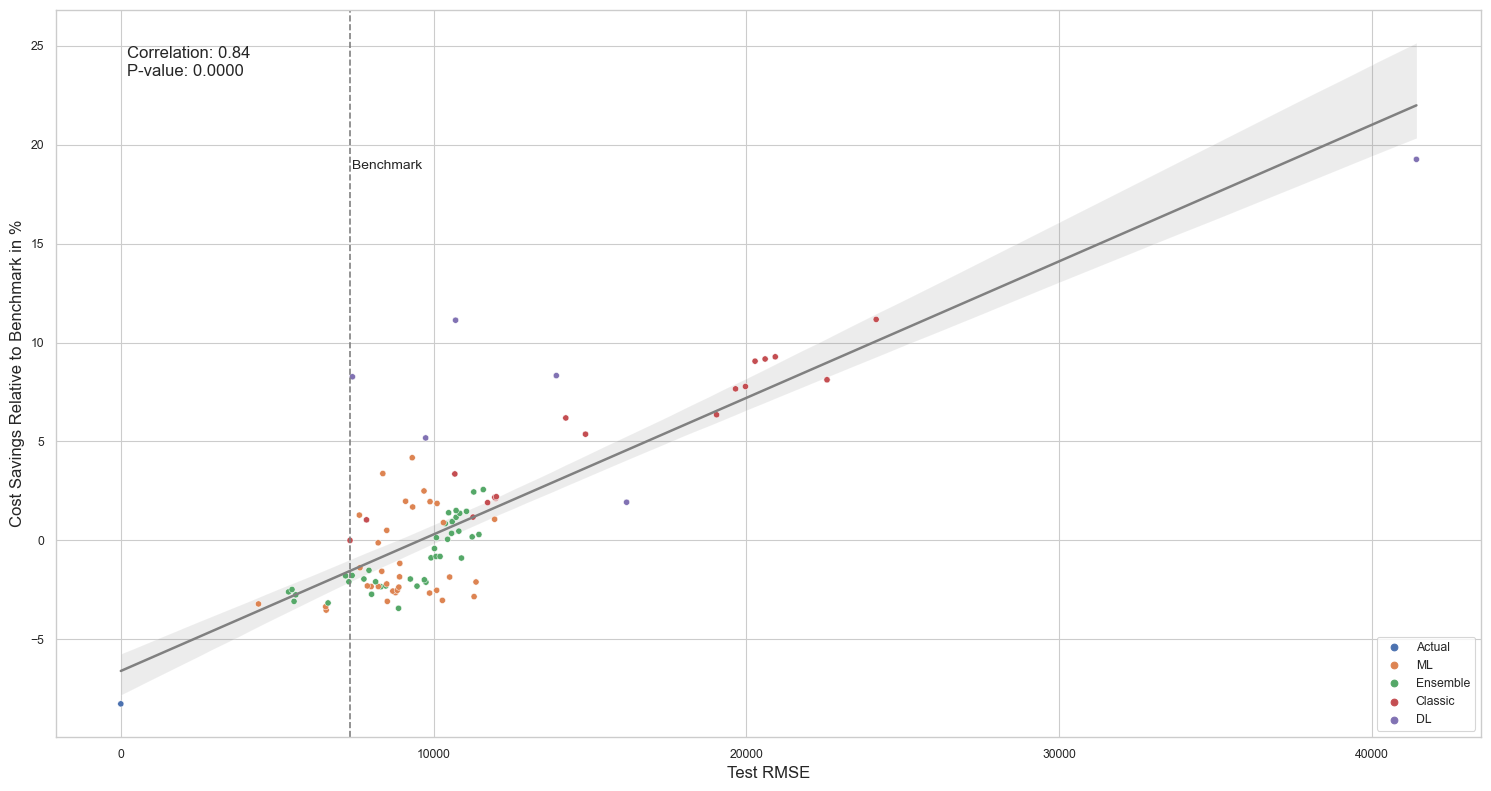

In [10]:
ens_metrics = pd.read_excel("../data/modelling_results/ensemble_metrics_v2.xlsx")

# Merge the two DataFrames based on the model names
merged_df = pd.merge(evaluation_df, ens_metrics, left_on='model', right_on='category')

# Apply the function to the DataFrame
merged_df['model_category'] = merged_df['model'].apply(categorize_model)

# Get the val_rmse score for "L_4_sarimax" model
sarimax_rmse = merged_df.loc[merged_df['model'] == "L_4_sarimax", 'pred_rmse'].values[0]

# Set Seaborn style for an academic format
sns.set(style="whitegrid")
sns.set_context("paper")

# Create the figure
plt.figure(figsize=(15, 8))

# Plot the regression line using sns.regplot
sns.regplot(x='pred_rmse', y='mean_savings_bench', data=merged_df, scatter=False, line_kws={'color':'grey'})

# Plot the points using sns.scatterplot
sns.scatterplot(x='pred_rmse', y='mean_savings_bench', data=merged_df, hue="model_category", s=20)

# Draw a vertical line for the "L_4_sarimax" model's val_rmse score
plt.axvline(sarimax_rmse, color='grey', linestyle='--')
plt.annotate('Benchmark', xy=(sarimax_rmse, merged_df['mean_savings_bench'].max()), 
             xytext=(sarimax_rmse+50, merged_df['mean_savings_bench'].max()), 
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             horizontalalignment='left', verticalalignment='top', fontsize=10)

# Calculate the correlation coefficient and p-value
corr_coeff, p_value = pearsonr(merged_df['pred_rmse'], merged_df['mean_savings_bench'])

# Annotate the plot with the correlation coefficient and p-value
plt.annotate(f'Correlation: {corr_coeff:.2f}\nP-value: {p_value:.4f}', 
             xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, verticalalignment='top')

# Set labels and title for the plot
plt.xlabel('Test RMSE', fontsize=12)
plt.ylabel('Cost Savings Relative to Benchmark in %', fontsize=12)

# Move the legend to the bottom right corner
plt.legend(loc='lower right')

# Display the plot
plt.tight_layout()
plt.savefig('../data/figures/scatter_rmse_cost.png', dpi=300, bbox_inches='tight')
plt.show()

## Scheduling

#### Planned workers

Boundry at: -15.966386554621847 excess planned workers
Boundry at: -15.966386554621847 excess planned workers
Slope 0: -0.35752250376768285, Intercept: -2.0920172348233135
Slope 1: -0.091713411054776, Intercept: 1.9139887704477698
Slope 2: 0.8269536929194603, Intercept: 1.951266427937988


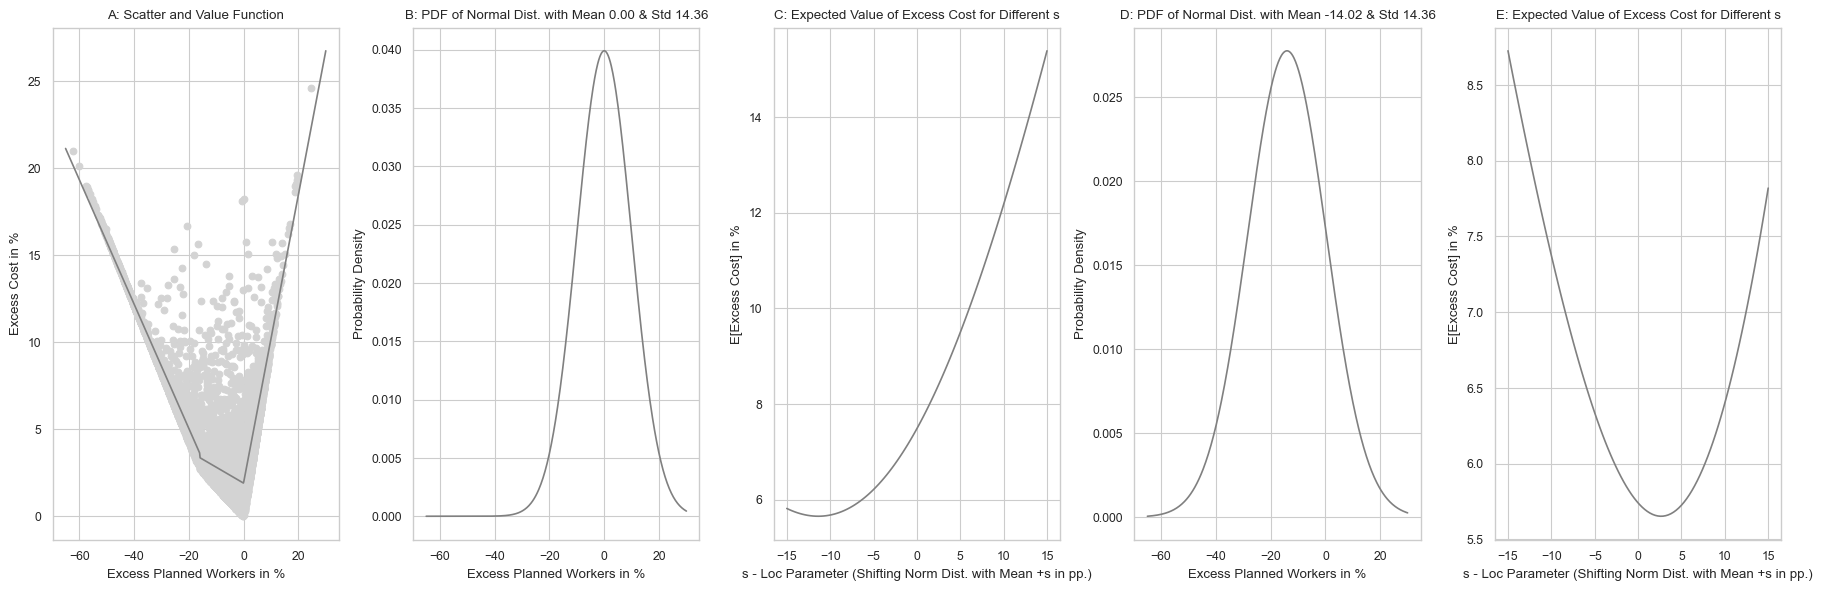

Tht expected value of y with mean = 0. and without s is approximately 7.4831
The value of s that minimises E[excess cost] is approximately -11.3720
The min expected value of y is approximately 5.6521
Tht expected value of y without actual mean s is approximately 5.7401
The value of s that minimises E[exces cost] is approximately 2.6530
The min expected value of y is approximately 5.6521


In [11]:

# Define excess function
def excess_function(model, bench):

    excess = np.round(((model - bench) / bench) * 100, 4)

    return excess

# Data (please keep this format)
scenario = 1
model = 'L_4_Time_Momentum_Lag_lgbm_L_4_Time_Momentum_Lag_Weather_xgb'
benchmark_model = "actual"

cost_excess = excess_function(np.sum(c_robust_dict[scenario][model]["cost"][:, :, :], axis=1).flatten(), 
                              np.sum(c_robust_dict[scenario][benchmark_model]["cost"][:, :, :], axis=1).flatten())

wp_excess = excess_function(np.sum(c_robust_dict[scenario][model]["w_p"][:, :, :], axis=1).flatten(), 
                              np.sum(c_robust_dict[scenario][benchmark_model]["w_p"][:, :, :], axis=1).flatten())

# Define the function y(x) based on the slopes and segments
def y_func(x, segements):
    for i in range(3):
        lower_bound, upper_bound = segments[i]
        if lower_bound <= x < upper_bound:
            return slopes[i] * x + intercepts[i]
    return 0  # Default value if x is out of all segments

def plot_figures(mean, std_dev):
    
    def linear_func(x, a, b):
        return a * x + b
    
    # Define the PDF of the normal distribution with mean (mean + s)
    def pdf_shifted(x, mean, s, std_dev):
        return (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - (mean + s)) / std_dev)**2)

    # Define the integrand for the expected value calculation with mean (mean + s)
    def integrand_shifted(x, mean, s, std_dev, segments):
        return y(x, segments) * pdf_shifted(x, mean, s, std_dev)

    # Function to calculate the expected value (for minimizing)
    def expected_value_to_minimize(s, mean, std_dev, segments):
        expected_value, _ = quad(integrand_shifted, -np.inf, np.inf, args=(mean, s, std_dev, segments))
        return expected_value

    # Define the PDF of the standard normal distribution
    def pdf(x, mean, std_dev):
        return (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev)**2)


    # Define the integrand for the expected value calculation
    def integrand(x, std_dev, segments):
        return y(x, segments) * pdf(x, std_dev)
    
    # Define boundry overtime boundry
    def overtime_boundry(p_o, p_p):
        
        # overtime equivilant to planned workers 
        p_op = (1+(p_o-p_p)/p_p)
        
        # 0.2 = shitft length, return in %
        boundry = (1/(0.2*p_op+1)-1)*100
        
        print(f"Boundry at: {boundry} excess planned workers")
        
        return boundry
    
    p_o = 95
    p_p = 100
    
    slopes = {}
    intercepts = {}
    segments = {}
    segments[0] = (-100, overtime_boundry(p_o, p_p)) 
    segments[1] = (overtime_boundry(p_o, p_p), 0) 
    segments[2] = (0, 100)

    # Loop through each segment and fit a linear model
    for i in range(3):
        lower_bound, upper_bound = segments[i]
        mask = (wp_excess > lower_bound) & (wp_excess <= upper_bound)
        x_data, y_data = wp_excess[mask], cost_excess[mask]
        popt, _ = curve_fit(linear_func, x_data, y_data)
        slopes[i], intercepts[i] = popt[0], popt[1] 
        
        print(f"Slope {i}: {slopes[i]}, Intercept: {intercepts[i]}")

    # Define the function y(x) based on the slopes and segments
    def y(x, segments):
        for i in range(3):
            lower_bound, upper_bound = segments[i]
            if lower_bound <= x < upper_bound:
                return slopes[i] * x + intercepts[i]
        return 0  # Default value if x is out of all segments

    # Minimize the expected value
    result = minimize_scalar(expected_value_to_minimize, args=(mean, std_dev, segments))
    optimal_s = result.x
    min_expected_value = result.fun
    
    # Calculate the expected value for s=0
    expected_value_s_zero = expected_value_to_minimize(0, mean, std_dev, segments)
    
    # Minimize the expected value for example
    result_0 = minimize_scalar(expected_value_to_minimize, args=(0, std_dev, segments))
    optimal_s_0 = result_0.x
    min_expected_value_0 = result_0.fun
    # Calculate the expected value for s=0
    expected_value_s_0_zero = expected_value_to_minimize(0, 0, std_dev, segments)
    
    # Generate data for plotting
    x_values = np.linspace(-65, 30, 500)
    y_values = [y(x, segments) for x in x_values]
    pdf_values = pdf(x_values, mean, std_dev)  # Now using custom_mean
    
    # generate 0,10 case 
    
    # Generate data for plotting
    x_values = np.linspace(-65, 30, 500)
    y_values = [y(x, segments) for x in x_values]
    pdf_values_0 = pdf(x_values, 0, 10)  # Now using custom_mean
    
    # Plotting
    plt.figure(figsize=(18, 6))

    # Original y(x) and PDF
    plt.subplot(1, 5, 1)
    plt.scatter(wp_excess, cost_excess, color = "lightgrey")
    plt.plot(x_values, y_values, color="grey")
    plt.title('A: Scatter and Value Function')
    plt.xlabel('Excess Planned Workers in %')
    plt.ylabel('Excess Cost in %')

    plt.subplot(1, 5, 2)
    plt.plot(x_values, pdf_values_0, color="grey")
    plt.title(f'B: PDF of Normal Dist. with Mean {0:.2f} & Std {std_dev:.2f}')
    plt.xlabel('Excess Planned Workers in %')
    plt.ylabel('Probability Density')

    # Expected value of y for different s
    plt.subplot(1, 5, 3)
    s_values = np.linspace(-15, 15, 100)
    expected_values = [expected_value_to_minimize(s, 0, std_dev, segments) for s in s_values]
    plt.plot(s_values, expected_values, color="grey")
    plt.title('C: Expected Value of Excess Cost for Different s')
    plt.xlabel('s - Loc Parameter (Shifting Norm Dist. with Mean +s in pp.)')
    plt.ylabel('E[Excess Cost] in %')

    plt.subplot(1, 5, 4)
    plt.plot(x_values, pdf_values, color="grey")
    plt.title(f'D: PDF of Normal Dist. with Mean {mean:.2f} & Std {std_dev:.2f}')
    plt.xlabel('Excess Planned Workers in %')
    plt.ylabel('Probability Density')

    # Expected value of y for different s
    plt.subplot(1, 5, 5)
    s_values = np.linspace(-15, 15, 100)
    expected_values = [expected_value_to_minimize(s, mean, std_dev, segments) for s in s_values]
    plt.plot(s_values, expected_values, color="grey")
    plt.title(f'E: Expected Value of Excess Cost for Different s')
    plt.xlabel('s - Loc Parameter (Shifting Norm Dist. with Mean +s in pp.)')
    plt.ylabel('E[Excess Cost] in %')

    plt.tight_layout()
    plt.savefig(f'../data/figures/excess_schedulling.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Tht expected value of y with mean = 0. and without s is approximately {expected_value_s_0_zero:.4f}")
    print(f"The value of s that minimises E[excess cost] is approximately {optimal_s_0:.4f}")
    print(f"The min expected value of y is approximately {min_expected_value_0:.4f}")
    
    print(f"Tht expected value of y without actual mean s is approximately {expected_value_s_zero:.4f}")
    print(f"The value of s that minimises E[exces cost] is approximately {optimal_s:.4f}")
    print(f"The min expected value of y is approximately {min_expected_value:.4f}")



    
# Standard deviation and mean of wp_excess
std_dev = np.std(wp_excess)
mean = np.mean(wp_excess)
    
# Call the function with your custom mean and std_dev
plot_figures(mean, std_dev)

## Weekly Savings Distribution

0 4.06
1 4.56
2 3.06
3 4.36
4 11.84
5 5.19
6 1.69
Total Median : 4.32
Total Mean : 5.33


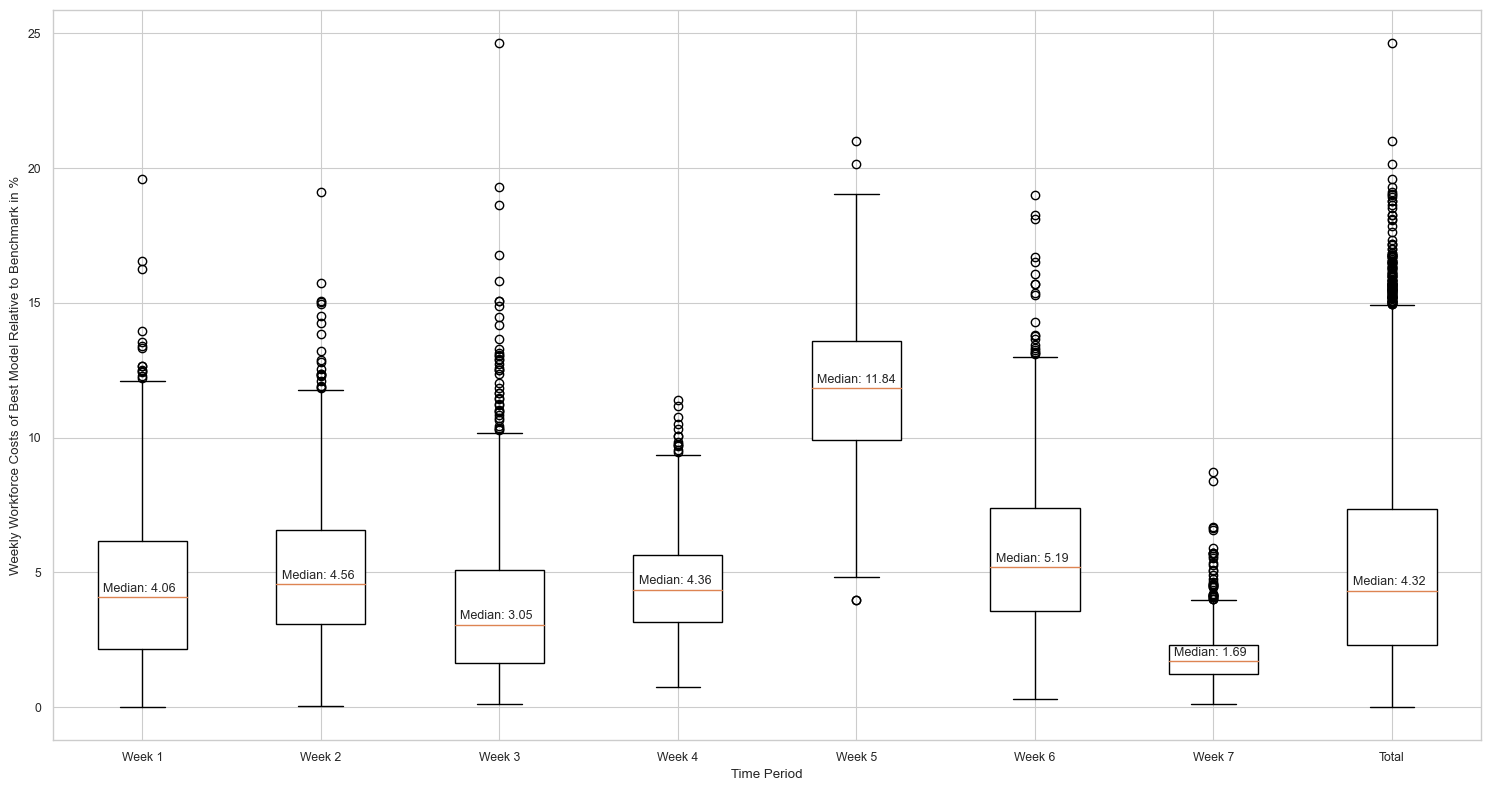

In [12]:
# Select data
model_data = np.sum(single_dict[evaluation_df.reset_index().model[1]]["cost"], axis=1).flatten()
bench_data = np.sum(single_dict[benchmark_model]["cost"], axis=1).flatten()

# Calculate relative performance for each week and total
# weekly
rel_per_weekly = []
for week in range(7):
    model_week = np.sum(single_dict[evaluation_df.reset_index().model[1]]["cost"][week,:,:], axis=0)
    bench_week = np.sum(single_dict[benchmark_model]["cost"][week,:,:], axis=0)
    rel_per = np.round((((model_week - bench_week) / bench_week) * 100), 2)
    rel_per_weekly.append(rel_per)
    
    print(week, np.round(np.median(rel_per),2))
    
# total
rel_t_per_bench = np.round((((model_data - bench_data) / bench_data) * 100), 2)
print("Total Median :", np.round(np.median(rel_t_per_bench),2))
print("Total Mean :", np.round(np.mean(rel_t_per_bench),2))

median_saving = np.round(np.median(rel_per_bench),2)
# Combine weekly and total data for boxplot
all_data = rel_per_weekly + [rel_t_per_bench]

# Create a figure
plt.figure(figsize=(15, 8))

# Create a subplot for the boxplot (1 row, 1 column, first plot)
plt.subplot(1, 1, 1)
box = plt.boxplot(all_data, vert=True, patch_artist=True, labels=[f"Week {i+1}" for i in range(7)] + ["Total"])
plt.xlabel('Time Period')
plt.ylabel('Weekly Workforce Costs of Best Model Relative to Benchmark in %')
plt.grid(True)

# Change the color of the boxplot to grey
for patch in box['boxes']:
    patch.set_facecolor('white')

# Annotate median values
for i, median in enumerate(box['medians']):
    median_x = []
    median_y = []
    for point in median.get_data()[1]:
        median_x.append(i + 1)
        median_y.append(point)
    plt.annotate(f'Median: {median_y[0]:.2f}', xy=(median_x[0], median_y[0]), xytext=(median_x[0]-0.22, median_y[0]+0.2),
                 fontsize=9)

# Show the plots
plt.tight_layout()
plt.savefig(f'../data/figures/box_savings.png', dpi=300, bbox_inches='tight')
plt.show()


### Amount of planned workers

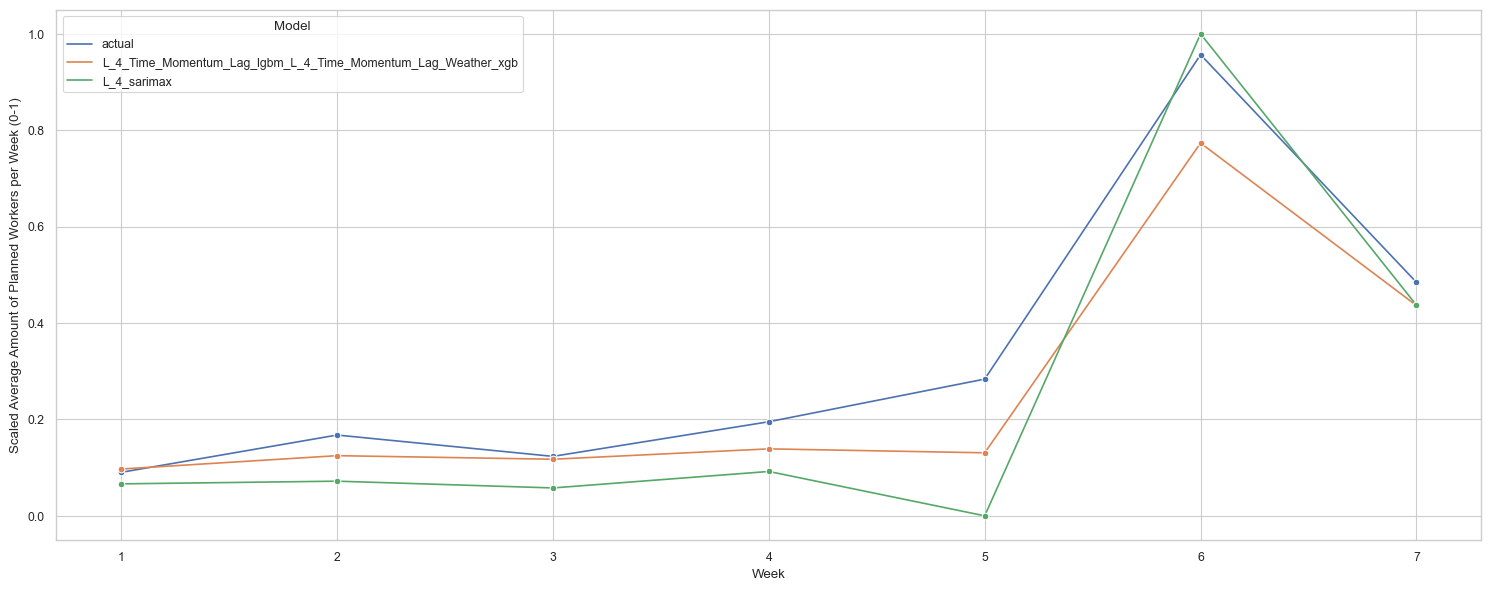

In [13]:
# Initialize an empty list to store the data
data_list = []

# Select data
for model in c_robust_dict[0].keys():
    for week in range(7):
        amount_planned_workers = np.mean(np.sum(c_robust_dict[1][model]["w_p"][week, :, :], axis=0).flatten())
        
        # Add week number, model name, and number of planned workers to list
        data_list.append([week+1, model, amount_planned_workers])

# Create a DataFrame from the list
planned_workers_df = pd.DataFrame(data_list, columns=['week', 'model', 'amount_planned_workers'])

# Plot
filtered_df = planned_workers_df.copy()

# Scale the 'amount_planned_workers' column between 0 and 1
scaler = MinMaxScaler()
filtered_df['scaled_planned_workers'] = scaler.fit_transform(filtered_df[['amount_planned_workers']])

# Set Seaborn style for an academic format
sns.set(style="whitegrid")
sns.set_context("paper")

# Plotting
plt.figure(figsize=(15, 6))
sns.lineplot(data=filtered_df, x='week', y='scaled_planned_workers', hue='model', marker='o')

# Setting title and labels
plt.xlabel('Week')
plt.ylabel('Scaled Average Amount of Planned Workers per Week (0-1)')
plt.legend(title='Model')

# Display the plot
plt.tight_layout()
plt.savefig('../data/figures/planned_workers_week_lgbm.png', dpi=300, bbox_inches='tight')
plt.show()


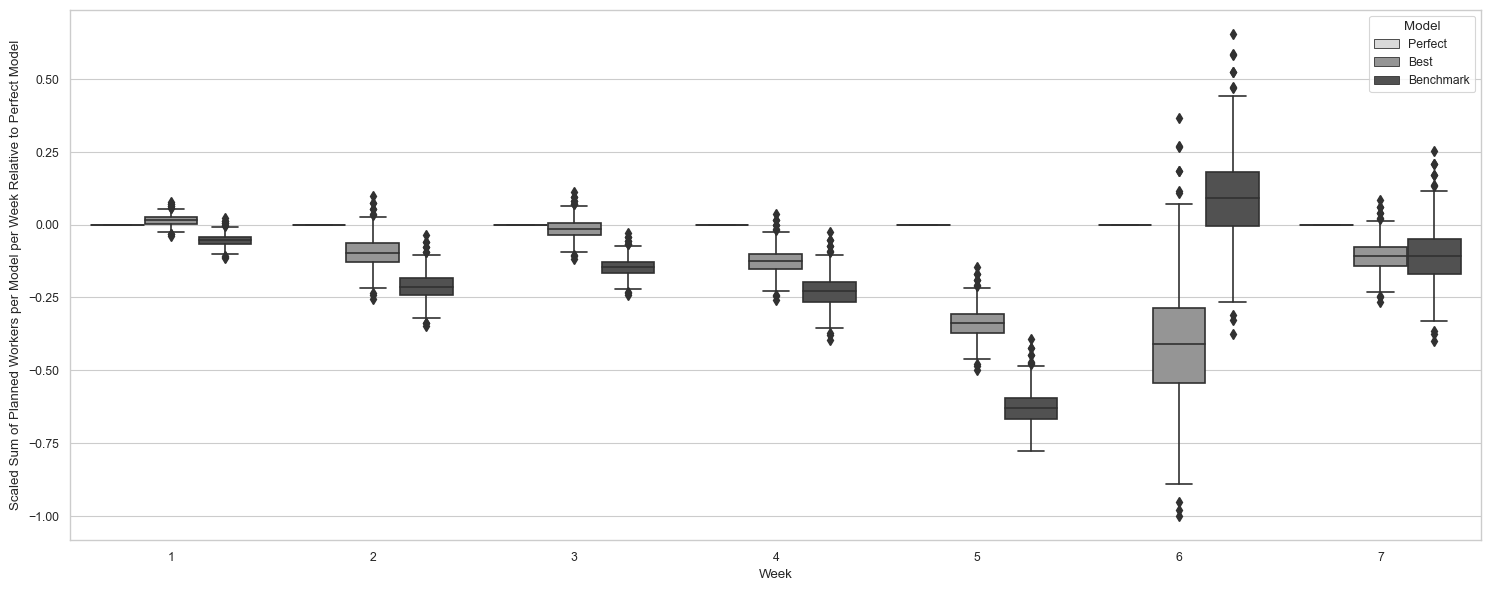

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize an empty list to store the data
data_list = []

# Initialize variables to keep track of the overall min and max values of w_p
overall_min = np.inf
overall_max = -np.inf

# Loop through each model and week to collect data
for model in c_robust_dict[0].keys():
    for week in range(7):
        
        amount_planned_workers = np.sum(c_robust_dict[0][model]["w_p"][week, :, :], axis=0).flatten() - np.sum(c_robust_dict[0]["actual"]["w_p"][week, :, :], axis=0).flatten()
        
        # Update overall min and max
        overall_min = min(overall_min, np.min(amount_planned_workers))
        overall_max = max(overall_max, np.max(amount_planned_workers))
        
        # Add week number, model name, and amount of planned workers to list
        for val in amount_planned_workers:
            data_list.append([week+1, model, val])

# Create a DataFrame from the list
planned_workers_df = pd.DataFrame(data_list, columns=['week', 'model', 'amount_planned_workers'])

# Scale the 'amount_planned_workers' column between overall_min and overall_max
# Find the absolute maximum value among the overall minimum and maximum values
abs_max = max(abs(overall_min), abs(overall_max))

# Conditionally scale the 'amount_planned_workers' column between -1 and 1
planned_workers_df['scaled_planned_workers'] = planned_workers_df['amount_planned_workers'].apply(lambda x: x / abs_max if abs_max != 0 else 0)



# Set Seaborn style for an academic format
sns.set(style="whitegrid")
sns.set_context("paper")

# Plotting
plt.figure(figsize=(15, 6))

# Create boxplots
ax = sns.boxplot(data=planned_workers_df, x='week', y='scaled_planned_workers', hue='model', palette="Greys")

# Setting title and labels
plt.xlabel('Week')
plt.ylabel('Scaled Sum of Planned Workers per Model per Week Relative to Perfect Model')

# Get the handles and labels from Seaborn's boxplot
handles, labels = ax.get_legend_handles_labels()

# Define your custom labels
custom_labels = ['Perfect', 'Best', 'Benchmark']

# Set the custom legend
plt.legend(handles, custom_labels, title='Model')

# Display the plot
plt.tight_layout()
plt.savefig('../data/figures/box_planned_workers_week_lgbm.png', dpi=300, bbox_inches='tight')
plt.show()


## Overcapacity

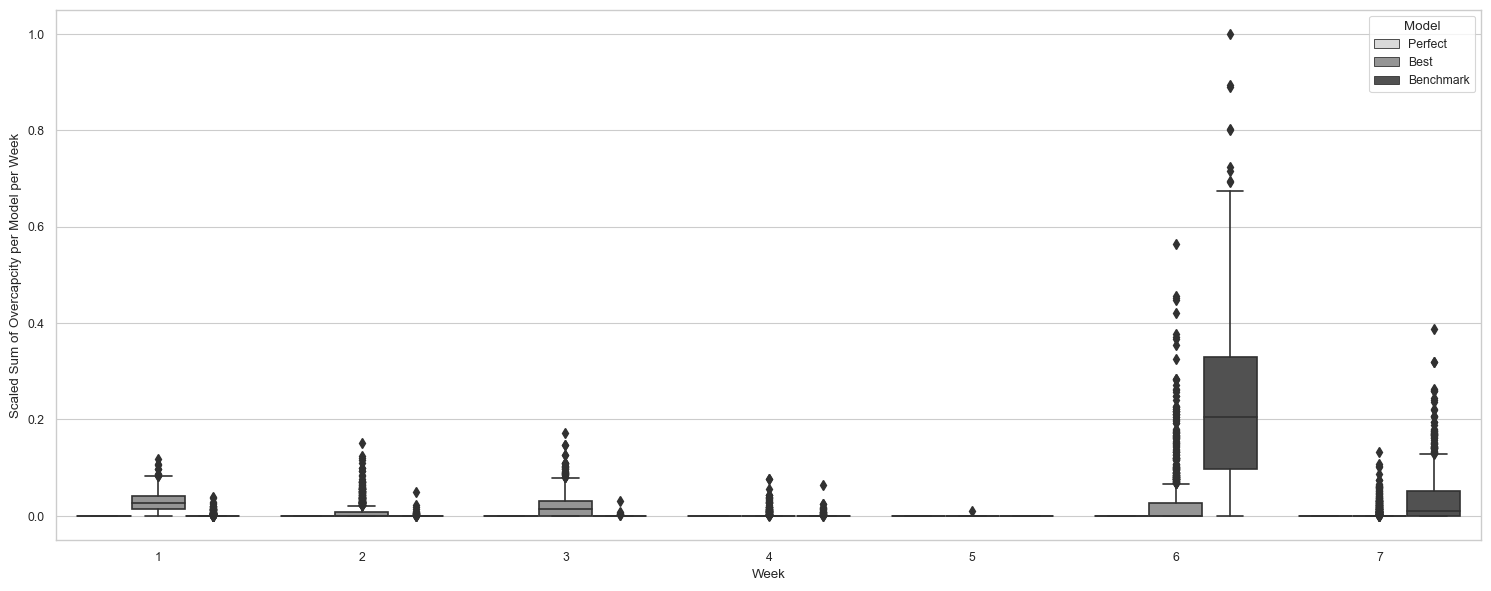

In [15]:
# Initialize an empty list to store the data
data_list = []

# Initialize variables to keep track of the overall min and max values of w_p
overall_min = np.inf
overall_max = -np.inf

# Loop through each model and week to collect data
for model in c_robust_dict[0].keys():
    for week in range(7):
        
        amount_planned_workers = np.sum(c_robust_dict[0][model]["v"][week, :, :], axis=0).flatten()
        
        # Update overall min and max
        overall_min = min(overall_min, np.min(amount_planned_workers))
        overall_max = max(overall_max, np.max(amount_planned_workers))
        
        # Add week number, model name, and amount of planned workers to list
        for val in amount_planned_workers:
            data_list.append([week+1, model, val])

# Create a DataFrame from the list
planned_workers_df = pd.DataFrame(data_list, columns=['week', 'model', 'amount_overcapacity'])

# Scale the 'amount_planned_workers' column between overall_min and overall_max
planned_workers_df['scaled_overcapacity'] = (planned_workers_df['amount_overcapacity'] - overall_min) / (overall_max - overall_min)

# Set Seaborn style for an academic format
sns.set(style="whitegrid")
sns.set_context("paper")

# Plotting
plt.figure(figsize=(15, 6))

# Create boxplots
ax = sns.boxplot(data=planned_workers_df, x='week', y='scaled_overcapacity', hue='model', palette="Greys")

# Setting title and labels
plt.xlabel('Week')
plt.ylabel('Scaled Sum of Overcapcity per Model per Week')

# Get the handles and labels from Seaborn's boxplot
handles, labels = ax.get_legend_handles_labels()

# Define your custom labels
custom_labels = ['Perfect', 'Best', 'Benchmark']

# Set the custom legend
plt.legend(handles, custom_labels, title='Model')

# Display the plot
plt.tight_layout()
plt.savefig('../data/figures/box_overcapacity_week_lgbm.png', dpi=300, bbox_inches='tight')
plt.show()

## Boxplot per week per scenario

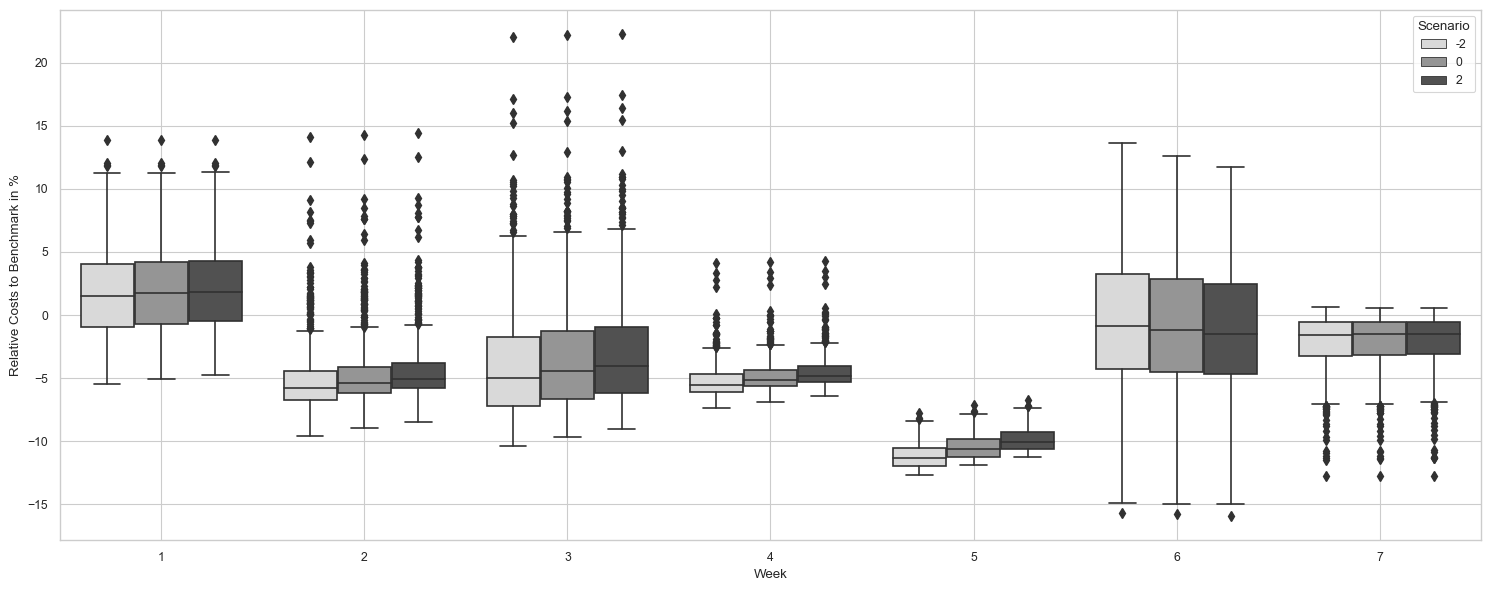

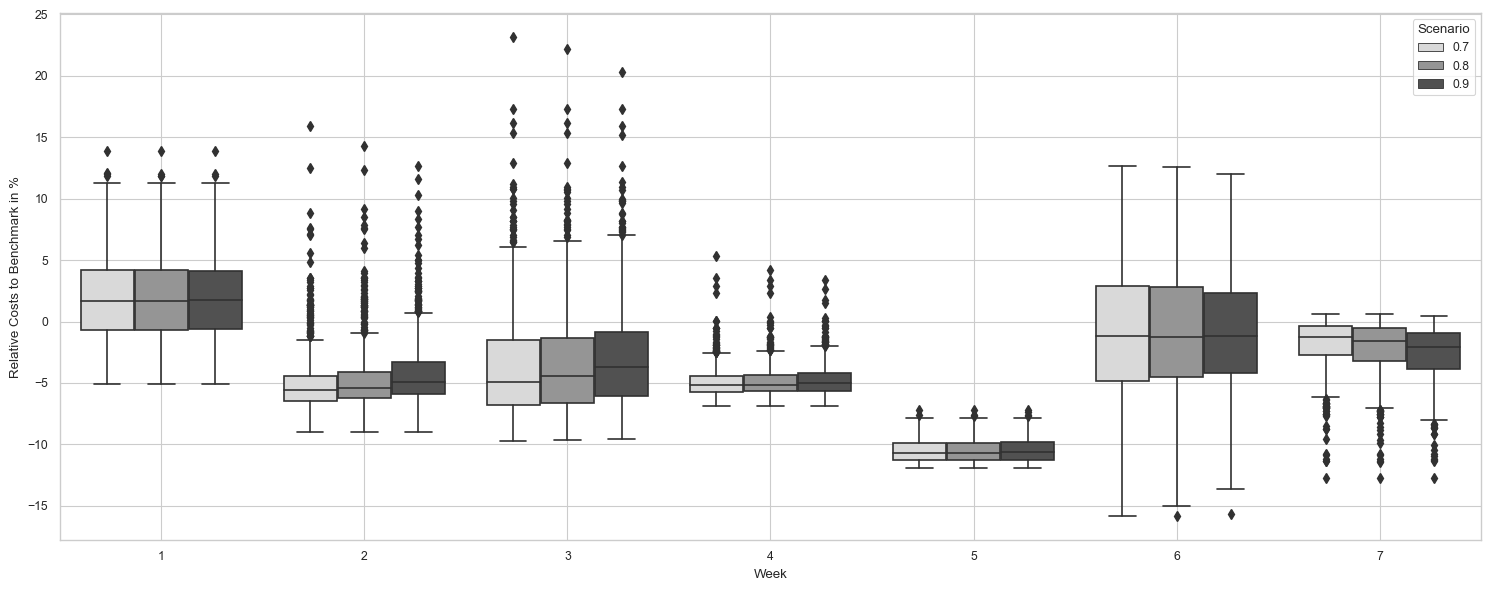

In [16]:
def create_cost_boxplot(robust_dict, scenario_label=["0.7", "0.8", "0.9"], path_name = "box_cost_p_scenario_comparison"):
    variable = "cost"
    # Initialize an empty list to store the data
    data_list = []
    
    # Model and Benchmark
    model = 'L_4_Time_Momentum_Lag_lgbm_L_4_Time_Momentum_Lag_Weather_xgb'
    benchmark_model = "L_4_sarimax"
    
    for week in range(7):  # Loop through each week
        for scenario in robust_dict.keys():  # Loop through each scenario
            weekly_model_data = np.sum(robust_dict[scenario][model][variable][week, :, :], axis=0)
            weekly_bench_data = np.sum(robust_dict[scenario][benchmark_model][variable][week, :, :], axis=0)
            
            rel_per = np.round((((weekly_model_data - weekly_bench_data)/ weekly_bench_data) * 100), 2)
            
            # Append week number, scenario, and relative percentage to list
            for val in rel_per:
                data_list.append([week+1, scenario, val])
    
    # Create a DataFrame from the list
    df = pd.DataFrame(data_list, columns=['week', 'scenario', 'rel_per'])
    
    # Set Seaborn style for an academic format
    sns.set(style="whitegrid")
    sns.set_context("paper")
    
    # Plotting
    plt.figure(figsize=(15, 6))
    
    # Create boxplots
    ax = sns.boxplot(data=df, x='week', y='rel_per', hue='scenario', palette="Greys")

    
    # Setting title and labels
    plt.xlabel('Week')
    plt.ylabel('Relative Costs to Benchmark in %')
    
    # Get the handles and labels from Seaborn's boxplot
    handles, labels = ax.get_legend_handles_labels()
    
    # Set the custom legend
    plt.legend(handles, scenario_label, title='Scenario')
    
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'../data/figures/{path_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage

create_cost_boxplot(c_robust_dict, scenario_label=["-2", "0", "2"], path_name="box_cost_c_scenario_comparison")
create_cost_boxplot(p_robust_dict, scenario_label=["0.7", "0.8", "0.9"], path_name = "box_cost_p_scenario_comparison")


## Boxplots per variable per scenario

actual
L_4_Time_Momentum_Lag_lgbm_L_4_Time_Momentum_Lag_Weather_xgb
L_4_sarimax
actual
L_4_Time_Momentum_Lag_lgbm_L_4_Time_Momentum_Lag_Weather_xgb
L_4_sarimax
actual
L_4_Time_Momentum_Lag_lgbm_L_4_Time_Momentum_Lag_Weather_xgb
L_4_sarimax
actual
L_4_Time_Momentum_Lag_lgbm_L_4_Time_Momentum_Lag_Weather_xgb
L_4_sarimax
actual
L_4_Time_Momentum_Lag_lgbm_L_4_Time_Momentum_Lag_Weather_xgb
L_4_sarimax
actual
L_4_Time_Momentum_Lag_lgbm_L_4_Time_Momentum_Lag_Weather_xgb
L_4_sarimax


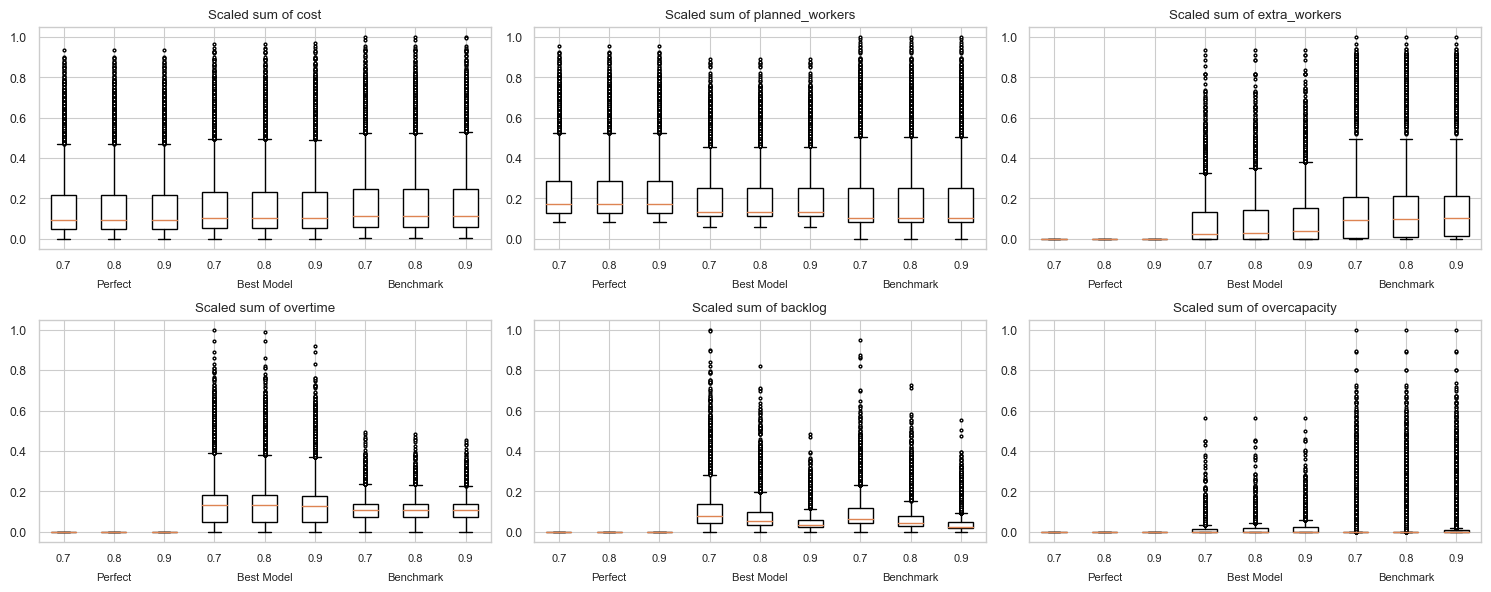

actual
L_4_Time_Momentum_Lag_lgbm_L_4_Time_Momentum_Lag_Weather_xgb
L_4_sarimax
actual
L_4_Time_Momentum_Lag_lgbm_L_4_Time_Momentum_Lag_Weather_xgb
L_4_sarimax
actual
L_4_Time_Momentum_Lag_lgbm_L_4_Time_Momentum_Lag_Weather_xgb
L_4_sarimax
actual
L_4_Time_Momentum_Lag_lgbm_L_4_Time_Momentum_Lag_Weather_xgb
L_4_sarimax
actual
L_4_Time_Momentum_Lag_lgbm_L_4_Time_Momentum_Lag_Weather_xgb
L_4_sarimax
actual
L_4_Time_Momentum_Lag_lgbm_L_4_Time_Momentum_Lag_Weather_xgb
L_4_sarimax


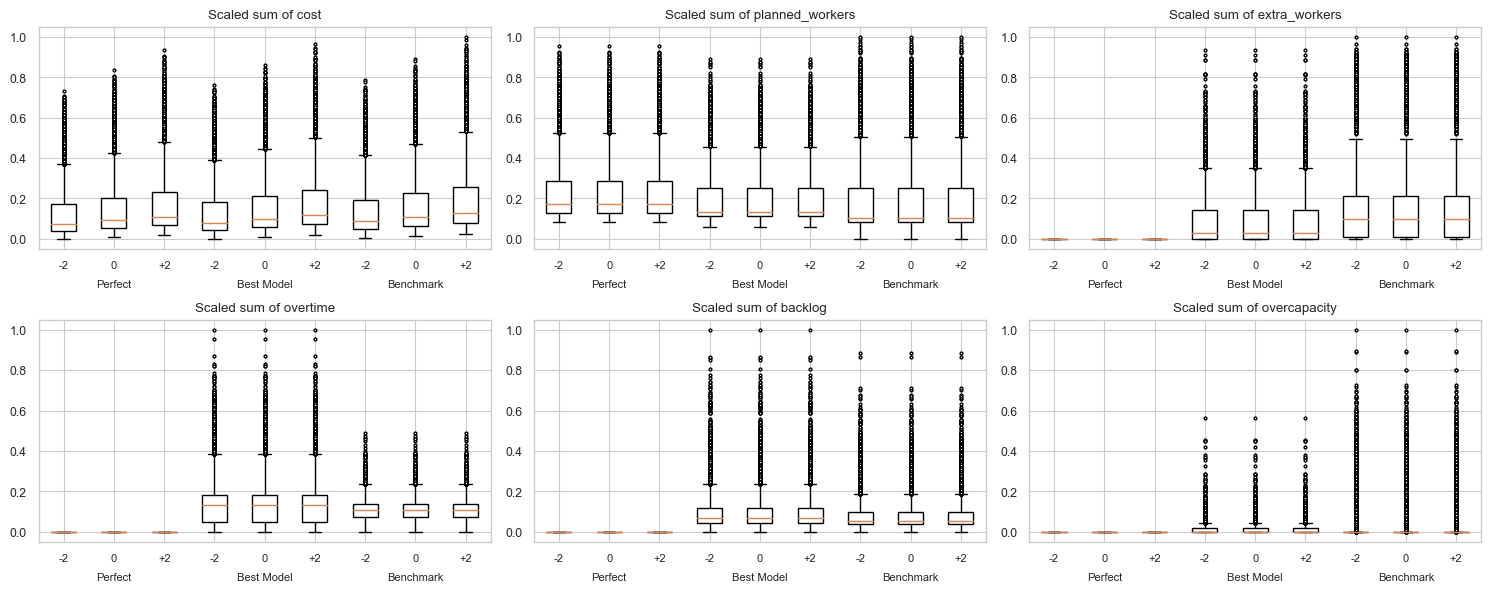

In [17]:
def scale_data(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data.reshape(-1, 1)).flatten()

def create_boxplot(robust_dict, model_label=["Perfect", "Best Model", "Benchmark"], scenario_label=["-2", "0", "+2"], path_name="box_test"):
    
    # Initialize the figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 6))

    # Flatten the axes for easier indexing
    axes = axes.flatten()

    # Define flier properties for boxplot
    flierprops = dict(marker='o', markerfacecolor='white', markersize=2, linestyle='none')
    
    models = robust_dict[0].keys()
    # Loop through variables and names
    for i, (variable, name) in enumerate(zip(variables, variables_name)):

        all_data = []
        xticklabels = []
        model_labels = []
        collected_data = []

        # Collect all data for this variable across all models and scenarios
        for model in models:
            print(model)
            for scenario in robust_dict.keys():
                data = np.sum(robust_dict[scenario][model][variable], axis=1).flatten()
                collected_data.append(data)

        # Convert list of arrays to a single numpy array
        collected_data = np.concatenate(collected_data)

        # Scale the collected data
        collected_data_scaled = scale_data(collected_data)

        # Loop through models and scenarios
        start_idx = 0
        for model_idx, model in enumerate(models):
            for scenario_idx, scenario in enumerate(robust_dict.keys()):
                # Extract and flatten data
                data = np.sum(robust_dict[scenario][model][variable], axis=1).flatten()
                end_idx = start_idx + len(data)

                # Get the corresponding scaled data
                data_scaled = collected_data_scaled[start_idx:end_idx]
                start_idx = end_idx

                # Append to all_data for boxplot
                all_data.append(data_scaled)

                # Append scenario label to xticklabels
                xticklabels.append(scenario_label[scenario_idx])

            # Append model label to model_labels
            model_labels.append(model_label[model_idx])

        # Create the boxplot on the appropriate subplot
        box = axes[i].boxplot(all_data, patch_artist=True, flierprops=flierprops)

        # Change the color of the boxplot to grey
        for patch in box['boxes']:
            patch.set_facecolor('white')
            
        
        # Set xticks and xticklabels
        axes[i].set_xticks(np.arange(1, len(xticklabels) + 1))
        axes[i].set_xticklabels(xticklabels, rotation=0, ha="center", fontsize=8)

        # Add second line of xticks for model names
        for j, model in enumerate(model_labels):
            start = len(robust_dict.keys()) * j + 1
            end = len(robust_dict.keys()) * (j + 1)
            pos = np.mean([start, end])
            axes[i].text(pos, -0.2, model, ha='center', va='top', fontsize=8)

        # Set title
        axes[i].set_title(f"Scaled sum of {name}")
    
    # add final legend that statest: Best Model: Ensemble of Customer LGBM and Customer xGBM-Weather
    #fig.legend(labels=["Best Model: Ensemble of Customer LGBM and Customer xGBM-Weather"], loc="upper right")

    # Show the plot
    plt.tight_layout()
    plt.savefig(f'../data/figures/{path_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Your code to populate c_robust_dict goes here
psi_box = create_boxplot(p_robust_dict, scenario_label=["0.7", "0.8", "0.9"], path_name="psi_box" )
cost_box = create_boxplot(c_robust_dict, path_name="cost_box")